In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from IPython import display
from tqdm.notebook import tqdm
from tensorflow.keras import layers


2.2.0


In [ ]:
!cp drive/My\ Drive/

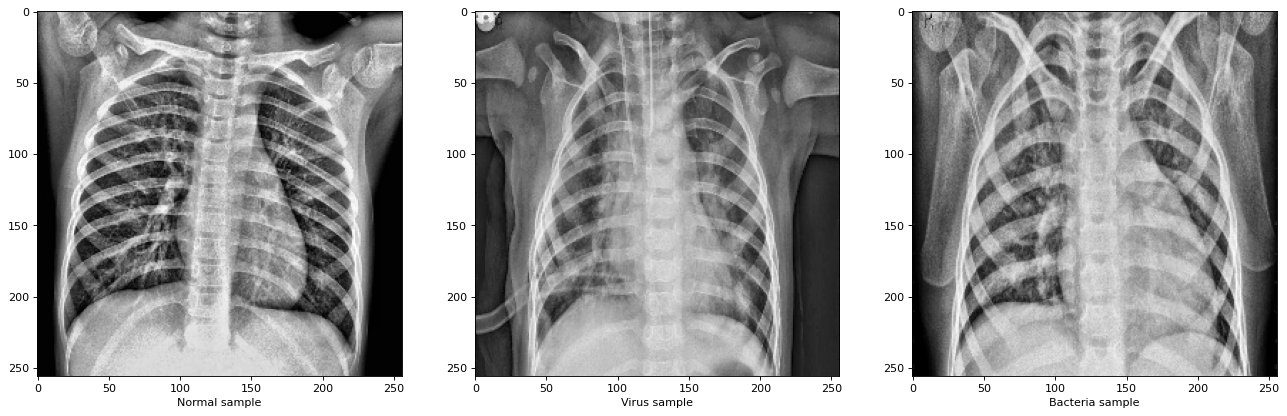

In [ ]:
PATH = "drive/My Drive/anomaly/"
output_path = PATH +  "output_anomaly/"
ckp_path = PATH + "ckp/"

training_data = np.load(PATH+"training_data/training_data_norm1d.npy")
test_data = np.load(PATH+"training_data/test_data_norm1d.npy")
viral_data = np.load(PATH+"training_data/abnormal_bacteria_data_norm1d.npy")
bacteria_data = np.load(PATH + "training_data/abnormal_virus_data_norm1d.npy")

fig = plt.figure(figsize=(20,20), dpi=80, facecolor='w')

plt.subplot(1,3,1)
plt.imshow((training_data[1200][0,...]+1)/2 , cmap='gray')
plt.xlabel('Normal sample')

plt.subplot(1,3,2)
plt.imshow((viral_data[0][0,...]+1)/2, cmap='gray')
plt.xlabel('Virus sample')

plt.subplot(1,3,3)
plt.imshow((bacteria_data[0][0,...]+1)/2, cmap='gray')
plt.xlabel('Bacteria sample')

plt.show()

Create model

In [ ]:

def make_generator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    model = tf.keras.Sequential()
    model.add(layers.Dense(2*2*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((2, 2, 1024)))

    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, 4, strides=2, padding='same', use_bias=False, kernel_initializer= initializer, activation='tanh'))
    print(model.output_shape)

    return model

generator = make_generator_model()
generator.summary()

(None, 256, 256, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         8388608   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 

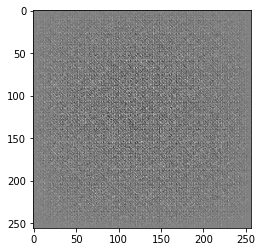

In [ ]:

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    input_layer = layers.Input(shape = [256,256,1])
    x = layers.Conv2D(512, 4 , strides=2, padding='same', use_bias=False, kernel_initializer=initializer, input_shape = (256,256,1) )(input_layer)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4 , strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4 , strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4 , strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    features = layers.LeakyReLU()(x)

    y = layers.Conv2D(1, 4 , strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(features)
    output = layers.Activation(tf.sigmoid)(y)

    return tf.keras.Model(inputs = input_layer, outputs = [output, features])

In [ ]:
discriminator = make_discriminator_model()
#decision, _ = discriminator(generated_image)
#plt.imshow(decision[0, :, :, 0])

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([1, noise_dim])
    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output, _  = discriminator(images, training=True)
      fake_output, _ = discriminator(generated_images, training=True)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    for k in range(4):
        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training = True)
            fake_output, _ = discriminator(generated_images, training = True)

            gen_loss = generator_loss(fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([1, noise_dim])

In [ ]:
def train(dataset, epochs):
  for epoch in tqdm(range(epochs)):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    #display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()


Time for epoch 1 is 535.8452513217926 sec


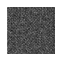


Time for epoch 2 is 526.3541989326477 sec


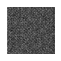


Time for epoch 3 is 525.7055103778839 sec


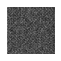


Time for epoch 4 is 525.6698746681213 sec


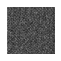


Time for epoch 5 is 527.3161463737488 sec


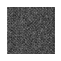


Time for epoch 6 is 528.1552047729492 sec


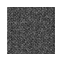


Time for epoch 7 is 527.3215281963348 sec


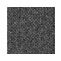


Time for epoch 8 is 528.2542531490326 sec


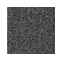


Time for epoch 9 is 528.0017845630646 sec


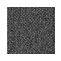


Time for epoch 10 is 528.4273543357849 sec


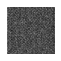


Time for epoch 11 is 526.9046056270599 sec


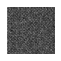


Time for epoch 12 is 526.5768287181854 sec


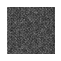


Time for epoch 13 is 526.6008729934692 sec


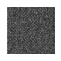


Time for epoch 14 is 527.6963284015656 sec


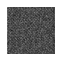


Time for epoch 15 is 526.9129600524902 sec


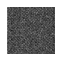


Time for epoch 16 is 525.6573600769043 sec


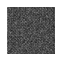


Time for epoch 17 is 526.4323103427887 sec


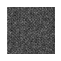


Time for epoch 18 is 528.1528313159943 sec


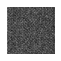


Time for epoch 19 is 528.1978530883789 sec


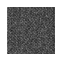


Time for epoch 20 is 529.0751564502716 sec


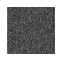


Time for epoch 21 is 529.4871022701263 sec


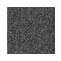


Time for epoch 22 is 528.3137407302856 sec


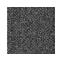


Time for epoch 23 is 527.6001844406128 sec


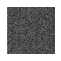


Time for epoch 24 is 527.0319564342499 sec


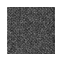


Time for epoch 25 is 525.609246969223 sec


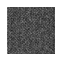


Time for epoch 26 is 525.1038541793823 sec


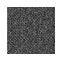


Time for epoch 27 is 525.0284748077393 sec


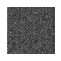


Time for epoch 28 is 524.9723443984985 sec


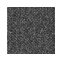


Time for epoch 29 is 525.0462872982025 sec


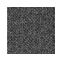


Time for epoch 30 is 524.295725107193 sec


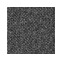


Time for epoch 31 is 525.05721616745 sec


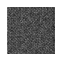


Time for epoch 32 is 524.836364030838 sec


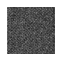


Time for epoch 33 is 525.2829945087433 sec


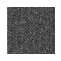


Time for epoch 34 is 525.1055574417114 sec


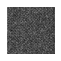


Time for epoch 35 is 525.2597661018372 sec


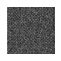


Time for epoch 36 is 525.2905585765839 sec


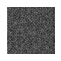


Time for epoch 37 is 525.4512319564819 sec


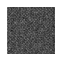


Time for epoch 38 is 525.0716683864594 sec


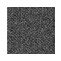


Time for epoch 39 is 525.219792842865 sec


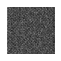


Time for epoch 40 is 525.0535356998444 sec


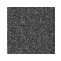


Time for epoch 41 is 525.1523771286011 sec


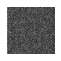


Time for epoch 42 is 524.8918042182922 sec


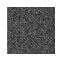


Time for epoch 43 is 525.1616103649139 sec


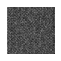


Time for epoch 44 is 525.211085319519 sec


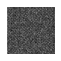


Time for epoch 45 is 525.3457140922546 sec


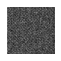


Time for epoch 46 is 524.9711410999298 sec


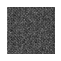


Time for epoch 47 is 525.0844852924347 sec


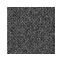


Time for epoch 48 is 525.6035585403442 sec


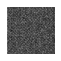


Time for epoch 49 is 527.7804234027863 sec


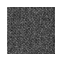


Time for epoch 50 is 528.437432050705 sec


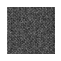

In [ ]:
train(training_data, EPOCHS)

In [ ]:
generator.load_weights(PATH + "ckp/anogan2_generator_weights_100epoch.h5")
discriminator.load_weights(PATH + "ckp/anogan2_discriminator_weights_100epoch.h5")

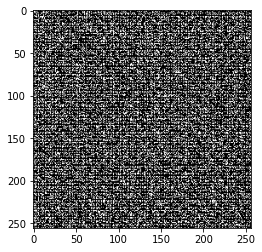

In [ ]:

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

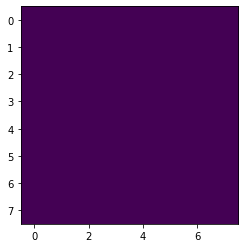

In [ ]:

decision, _ = discriminator(generated_image)
plt.imshow(decision[0, :, :, 0])

In [ ]:
latent_vector =  tf.random.normal([1, 100])
def anomaly_loss(test_data, g_data, Lambda = 0.1):
    _, feat_test = discriminator(test_data)
    _, feat_fake = discriminator(g_data)

    loss_residual = tf.reduce_sum(tf.abs(test_data - g_data))
    loss_discrimination = tf.reduce_sum(tf.abs(feat_test - feat_fake ))

    loss_ano = (1-Lambda)*loss_residual  + Lambda * loss_discrimination

    return loss_ano

z_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:

def lat_train(real_image, step):
    with tf.GradientTape() as z_tape:
        fake = generator(latent_vector, training = True)

        an_loss = anomaly_loss(real_image, fake)

        z_grads  = z_tape.gradient(an_loss, generator.trainable_variables)
        z_optimizer.apply_gradients(zip(z_grads, generator.trainable_variables))

    return an_loss



In [ ]:
discriminator.save_weights(PATH + "ckp/anogan2_discriminator_weights_100epoch.h5")
generator.save_weights(PATH + "ckp/anogan2_generator_weights_100epoch.h5")

In [ ]:
latent_space = []
auc = []
i = 0
for test_image in test_data:
    print("image:", i+1, " from:", len(test_data))
    for step in tqdm(range(401)):

        loss =  lat_train(test_image, step)

        if step == 400:
            latent_space.append(latent_vector)
            if loss >500:
                auc.append(1)
            else:
                auc.append(0)
    i+= 1


image: 1  from: 234



image: 2  from: 234



image: 3  from: 234



image: 4  from: 234



image: 5  from: 234



image: 6  from: 234



image: 7  from: 234



image: 8  from: 234



image: 9  from: 234



image: 10  from: 234



image: 11  from: 234



image: 12  from: 234



image: 13  from: 234



image: 14  from: 234



image: 15  from: 234



image: 16  from: 234


KeyboardInterrupt: ignored

In [ ]:

noise = tf.random.normal([1, 100])
generated_image = generator(seed, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
def compare_images(real_image, generated, threshold = 50):
    score = anomaly_loss(real_image, generated)
    real = real_image[0]
    fake = tf.keras.backend.get_value(generated[0, :, :, 0])

    real_image = ((real + 1 )/2) * 255
    generated = ((fake + 1) /2) * 255

    negative = np.zeros_like(real_image)

    diff = real_image - generated

    diff[diff <= threshold] = 0

    anomaly_img = np.zeros(shape = (256,256, 3))
    anomaly_img[:, :, 0] = real_image - diff
    anomaly_img[:, :, 1] = real_image - diff
    anomaly_img[:, :, 2] = real_image - diff
    anomaly_img[:, :, 0] = anomaly_img[:, :, 0] + diff

    anomaly_img = np.array(anomaly_img, np.uint8)

    fig, plots = plt.subplots(1, 4)
    if auc[0]==0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')

    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_image, cmap='gray', label='real')
    plots[1].imshow(generated, cmap='gray')
    plots[2].imshow(diff, cmap='gray')
    plots[3].imshow(anomaly_img)

    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')







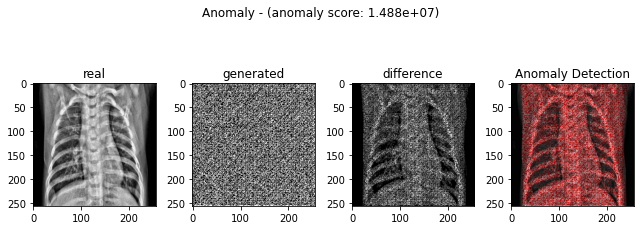

In [ ]:
gen = generator(latent_space[0])
compare_images( test_data[0] , gen)